In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import pytorch
import torch
import matplotlib.pyplot as plt
from SIRD_dualvar_simplified_deepxde_class import SIRD_deepxde_net, Plot
# from SIRD_d import SIRD_deepxde_net, Plot
# from SIRD_deepxde_class import Plot
# from ODE_SIR_copy import ODESolver

from ODE_SIRD_reinfection_class import SIRD2VAR, static_params_1, init_condtions_1, t_intro_var2, n_intro_var2


Using backend: pytorch



0.5 0.35714285714285715
0.075 0.01875


In [2]:
seed = 0
np.random.seed(seed)
dde.config.set_random_seed(seed)

In [3]:
solver = SIRD2VAR.solve_by_params_alpha_tau

# Create synthetic data

In [4]:
# alpha_real = 0.2
# beta_real = 0.05
# gamma_real = 0.01

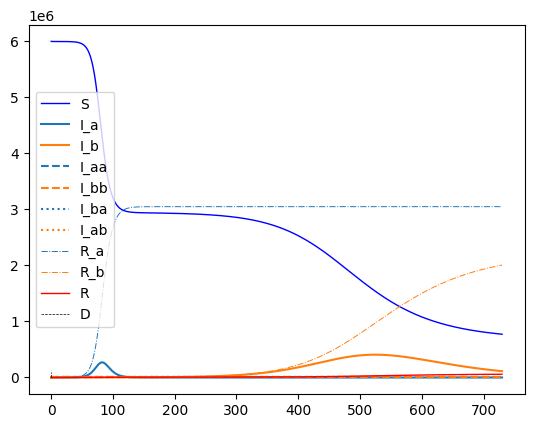

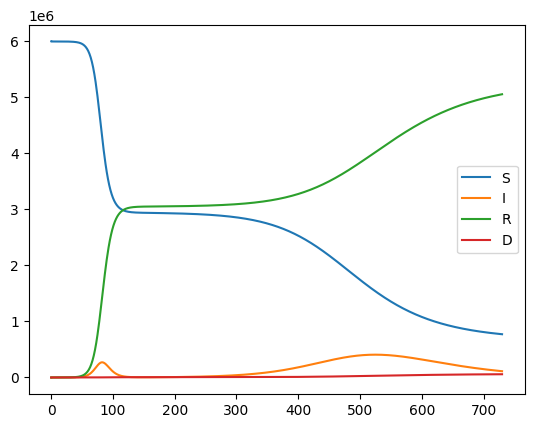

In [5]:
# import ODE_SIR
# solver = ODE_SIR.ODESolver()
# t_synth, wsol_synth, N = solver.solve_SIRD(alpha_real, beta_real, gamma_real)
# solver.plot_SIRD(t_synth, wsol_synth)

time_delta = [0,2*365]
# import ODE_SIRD_reinfection_class as sird2

sird_model = SIRD2VAR(init_condtions_1, static_params_1, time_delta, t_intro_var2, n_intro_var2)
t_synth, wsol_synth = sird_model.get_wsol_as_SIRD()
t_synth, wsol_synth_full = sird_model.get_wsol()
sird_model.plot_wsol()
sird_model.plot_sird()


Use cell below if we want to subset timestep - ie simulate if we are at an early stage in the pandemic so have limited data

In [6]:
# keep this even if not subsetting
t = t_synth
wsol = wsol_synth

# subset
# max_timestep = 300
# t_bool = t_synth < max_timestep
# t = t_synth[t_bool]
# wsol = wsol_synth[t_bool]

# Create model
Code has been wrapped in a custom class that wraps around the deepxde model

In [7]:
model = SIRD_deepxde_net(t, wsol, with_neumann=False)
print(model)

In [8]:
hyper_print_every = 1000
model.init_model(print_every=hyper_print_every)

Compiling model...
'compile' took 0.000115 s



In [19]:
model.train_model(iterations=5000 ,print_every=hyper_print_every)

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
10000     [6.11e-06, 2.85e-07, 2.65e-07, 2.93e-08, 4.60e-12, 4.74e-11, 5.55e-15, 9.76e-11, 7.70e-06, 2.10e-05, 1.18e-05, 4.39e-07, 1.66e-08, 8.80e-08, 1.76e-07, 2.09e-10]    [6.11e-06, 2.85e-07, 2.65e-07, 2.93e-08, 4.60e-12, 4.74e-11, 5.55e-15, 9.76e-11, 7.70e-06, 2.10e-05, 1.18e-05, 4.39e-07, 1.66e-08, 8.80e-08, 1.76e-07, 2.09e-10]    []  
10100     [5.82e-06, 2.65e-07, 2.50e-07, 2.70e-08, 1.42e-12, 6.02e-11, 1.14e-11, 9.35e-11, 7.01e-06, 1.98e-05, 1.17e-05, 3.71e-07, 1.52e-08, 7.46e-08, 1.59e-07, 2.84e-10]    [5.82e-06, 2.65e-07, 2.50e-07, 2.70e-08, 1.42e-12, 6.02e-11, 1.14e-11, 9.35e-11, 7.01e-06, 1.98e-05, 1.17e-05, 3.7

# Investigate output
First use the predicted parameters from the neural network to solve the ODE

In [20]:
print(f"Best train step: {model.model.train_state.best_step}")
params_nn = model.get_best_params()
# print('Alpha_a: {}, Alpha_b: {}, Alpha_aa: {}, Alpha_bb: {}, Alpha_ba: {}, Alpha_ab: {}, beta_a: {}, beta_b: {}, gamma_a: {}, gamma_b: {}'.format(*params_nn))
# print('Alpha_a: {}, Alpha_b: {}, beta_a: {}, beta_b: {}, gamma_a: {}, gamma_b: {}'.format(*params_nn))
print('Alpha_a: {}, Alpha_b: {}, tau_a: {}, tau_b: {}, gamma_a: {}, gamma_b: {}'.format(*params_nn))
# alpha_a_nn, alpha_b_nn, beta_a_nn, beta_b_nn, gamma_a_nn, gamma_b_nn = params_nn
t_nn_param, wsol_nn_param, N_nn_param = solver(*params_nn)
# plt.plot(t_nn_param, wsol_nn_param)

Alpha_a: 0.0691, Alpha_b: 0.0618, tau_a: 1.77, tau_b: 1.75, gamma_a: 0.000119, gamma_b: 9.63e-07


10100

In [21]:
# we need to set the synthetic data as it comes from outside the network
# the two functions below sets the synthetic data
model.set_synthetic_data(t_synth, wsol_synth_full) 
model.set_nn_synthetic_data(t_nn_param, wsol_nn_param)

In [22]:
plot = Plot(model) # class that contains plotting functions

The plots below show two things:  
* A comparison between the data we have and what the PINN predicts in this range
* A comparison between the synthetic data in the whole range and the result from using the predicted parameters in the ODE solver

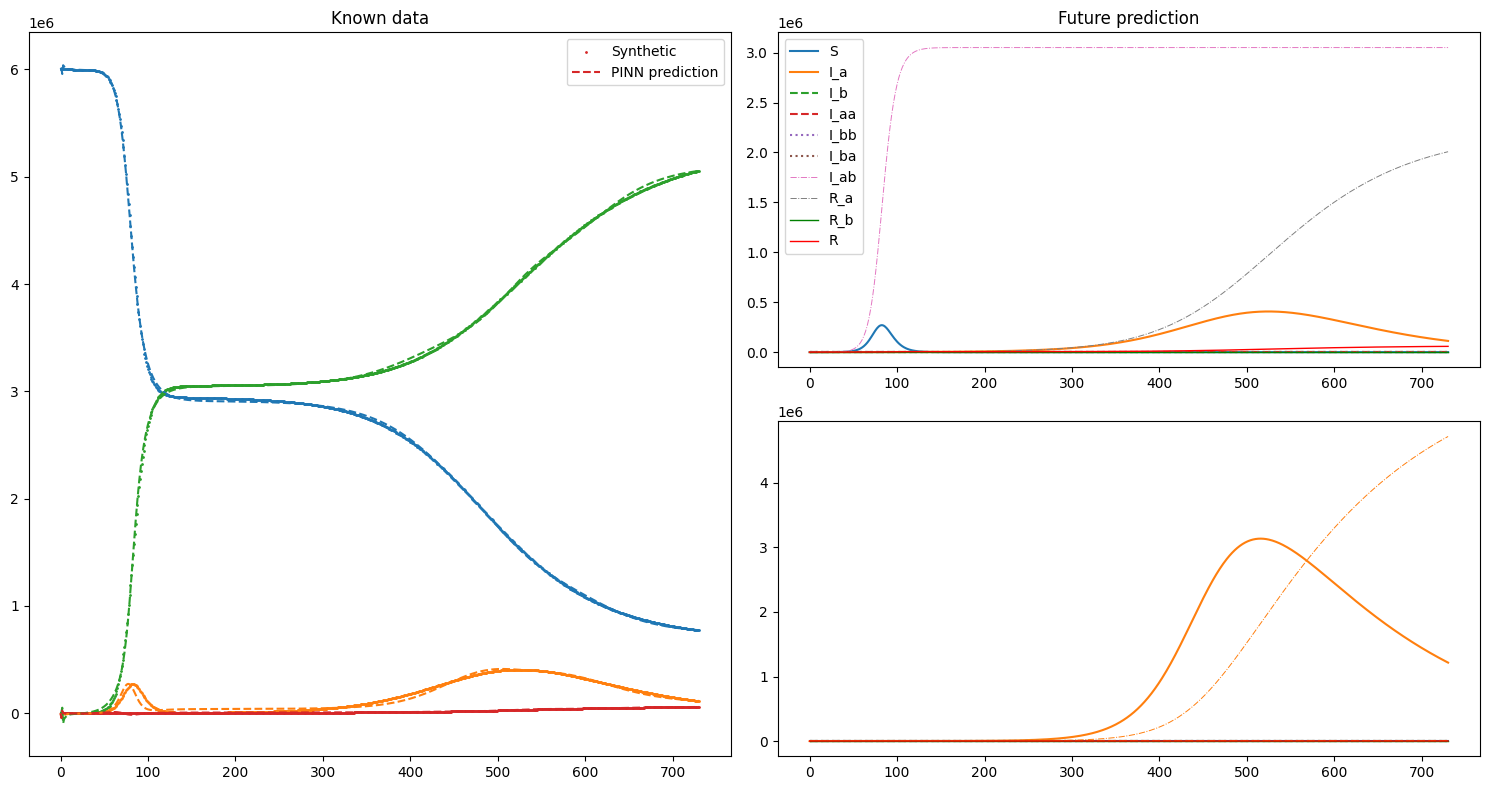

In [23]:
plot.show_known_and_prediction()

# Same as before with even less data, less data doesn't make sense for parameter estimation
The timing of the data is important. We want to predict as early as possible in the pandemic, so investigate what the effect is of having less data.

In [ ]:
max_timestep = 350
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [ ]:
model_less = SIRD_deepxde_net(t, wsol)
model_less.init_model(print_every=1000)
model_less.train_model(iterations=11000)

In [ ]:
params_nn_less = model_less.get_best_params()
print('Alpha_a: {}, Alpha_b: {}, Alpha_aa: {}, Alpha_bb: {}, Alpha_ba: {}, Alpha_ab: {}, beta_a: {}, beta_b: {}, gamma_a: {}, gamma_b: {}'.format(*params_nn_less))
t_nn_param, wsol_nn_param, N_nn_param = solver(*params_nn_less)

In [ ]:
model_less.set_synthetic_data(t_synth, wsol_synth)
model_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less = Plot(model_less)

In [ ]:
plot_less.show_known_and_prediction()

# Even less data

In [ ]:
max_timestep = 250
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [ ]:
model_less_2 = SIRD_deepxde_net(t, wsol)
model_less_2.init_model(print_every=1000)
model_less_2.train_model(iterations=11000)

In [ ]:
alpha_nn, beta_nn, gamma_nn = model_less_2.get_best_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver(_,alpha_nn, beta_nn, gamma_nn)

In [ ]:
model_less_2.set_synthetic_data(t_synth, wsol_synth)
model_less_2.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_less_2 = Plot(model_less_2)

In [ ]:
plot_less_2.show_known_and_prediction()

# With noise

In [ ]:
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

In [ ]:
wsol = solver.add_noise(wsol, scale=150000)

In [ ]:
solver.plot_SIRD_scatter(t, wsol)

In [ ]:
model_noise = SIRD_deepxde_net(t, wsol)
model_noise.init_model(print_every=1000)
model_noise.train_model(iterations=10000)

In [ ]:
alpha_nn, beta_nn, gamma_nn = model_noise.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)

In [ ]:
model_noise.set_synthetic_data(t_synth, wsol_synth)
model_noise.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise = Plot(model_noise)

In [ ]:
plot_noise.show_known_and_prediction()

In [ ]:
model_noise_neumann = SIRD_deepxde_net(t, wsol, with_neumann=True)
model_noise_neumann.init_model(print_every=1000)
model_noise_neumann.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_neumann.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_neumann.set_synthetic_data(t_synth, wsol_synth)
model_noise_neumann.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_neumann = Plot(model_noise_neumann)
plot_noise_neumann.show_known_and_prediction()

In [ ]:
max_timestep = 85
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]
wsol = solver.add_noise(wsol, scale=150000)

model_noise_less = SIRD_deepxde_net(t, wsol)
model_noise_less.init_model(print_every=1000)
model_noise_less.train_model(iterations=10000)
alpha_nn, beta_nn, gamma_nn = model_noise_less.get_predicted_params()
print(f'Alpha: {alpha_nn}, beta: {beta_nn}, gamma: {gamma_nn}')
t_nn_param, wsol_nn_param, N_nn_param = solver.solve_SIRD(alpha_nn, beta_nn, gamma_nn)
model_noise_less.set_synthetic_data(t_synth, wsol_synth)
model_noise_less.set_nn_synthetic_data(t_nn_param, wsol_nn_param)
plot_noise_less = Plot(model_noise_less)
plot_noise_less.show_known_and_prediction()

# Normal neural network

In [ ]:
from SIRD_normal_nn import SIRD_net
max_timestep = 100
t_bool = t_synth < max_timestep
t = t_synth[t_bool]
wsol = wsol_synth[t_bool]

net = SIRD_net(t, wsol)
net.train()
net.plot(t_synth, wsol_synth)